In [1]:
# If you're in Jupyter
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
# Load the data (updated for the warning)
df = pd.read_csv("./output/mf_hmf_manual_v3.txt", sep=r"\s+", comment="#", header=None)

# Check the shape just to be sure
print(df.shape)  # should be (n_samples, at least 4): omega_m, sigma8, prior, post

# You’ll need to check how many columns you have
# Assuming the order is: omega_m, sigma8_input, prior, posterior
df.columns = ["omega_m", "sigma8", "prior", "posterior"]

(10000, 4)


<>:7: SyntaxWarning: invalid escape sequence '\O'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\O'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2322782/1080225538.py:7: SyntaxWarning: invalid escape sequence '\O'
  axes[0].set_title("Trace Plot: $\Omega_m$")
/tmp/ipykernel_2322782/1080225538.py:13: SyntaxWarning: invalid escape sequence '\s'
  axes[1].set_title("Trace Plot: $\sigma_8$")


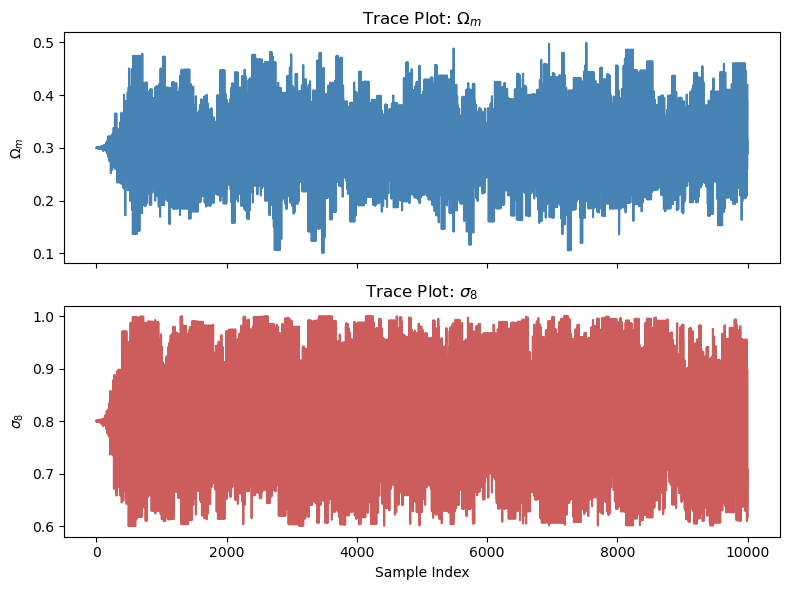

In [10]:
# Create figure with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Trace plot for omega_m
axes[0].plot(df["omega_m"], color='steelblue')
axes[0].set_ylabel(r'$\Omega_m$')
axes[0].set_title("Trace Plot: $\Omega_m$")

# Trace plot for sigma8
axes[1].plot(df["sigma8"], color='indianred')
axes[1].set_ylabel(r'$\sigma_8$')
axes[1].set_xlabel("Sample Index")
axes[1].set_title("Trace Plot: $\sigma_8$")

plt.tight_layout()
plt.show()


Removed no burn in


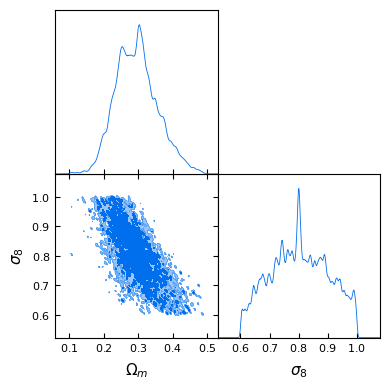

In [11]:
%matplotlib inline
from getdist import MCSamples, plots

# Extract parameter columns (adjust index if needed)
samples = df[["omega_m", "sigma8"]].values  # [omega_m, sigma_8]

# Parameter names and labels
names = ['omega_m', 'sigma8']
labels = [r'\Omega_m', r'\sigma_8']

# Create MCSamples object
mc_samples = MCSamples(samples=samples, names=names, labels=labels)

# Triangle plot
g = plots.getSubplotPlotter()
#g.settings.fine_bins_2D = 100  # default is 50
g.triangle_plot(mc_samples, filled=True)
plt.show()

/global/homes/x/xintang/anaconda3/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


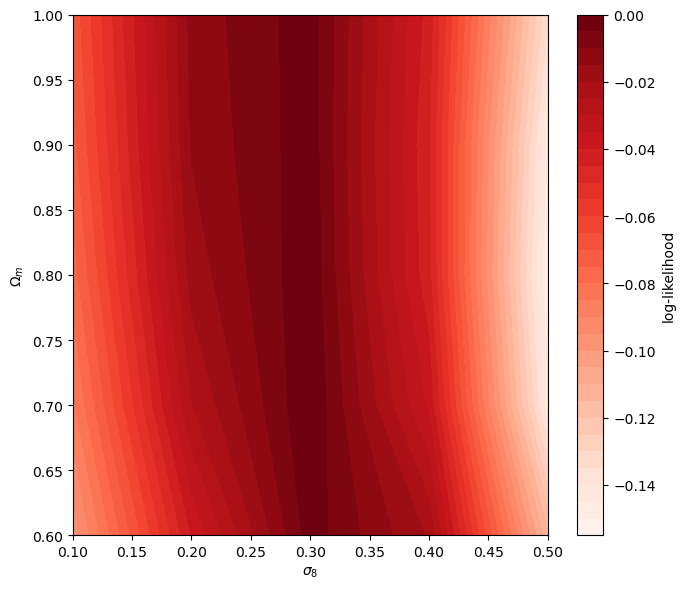

In [12]:
%matplotlib inline
from hmf import MassFunction
import scipy.interpolate

# Grid setup
omega_vals = np.linspace(0.1, 0.5, 5)
sigma_vals = np.linspace(0.6, 1.0, 5)
loglike_grid = np.zeros((len(omega_vals), len(sigma_vals)))

# Fixed data setup (same as your mock setup)
z = 0.1
mf_ref = MassFunction(z=z, sigma_8=0.81,
                      cosmo_params={"H0": 70, "Om0": 0.28, "Ob0": 0.04},
                      Mmin=13, Mmax=15, dlog10m=0.4,
                      hmf_model="Tinker08", n=0.96)
mass_obs = mf_ref.m
obs = mf_ref.dndlnm.copy()
sigma = np.maximum(0.1 * obs, 1e-3)

# Loop over grid
for i, omega in enumerate(omega_vals):
    for j, sig8 in enumerate(sigma_vals):
        mf_model = MassFunction(z=z, sigma_8=sig8,
                                cosmo_params={"H0": 70, "Om0": omega, "Ob0": 0.04},
                                Mmin=13, Mmax=15, dlog10m=0.4,
                                hmf_model="Tinker08", n=0.96)
        interp = scipy.interpolate.interp1d(np.log(mf_model.m), mf_model.dndlnm, kind="linear", bounds_error=False, fill_value="extrapolate")
        model_vals = interp(np.log(mass_obs))
        chi2 = np.sum(((obs - model_vals) / sigma) ** 2)
        loglike_grid[i, j] = -0.5 * chi2

# Plot it
plt.figure(figsize=(7, 6))
omega_mesh, sigma_mesh = np.meshgrid(sigma_vals, omega_vals)
contour = plt.contourf(sigma_mesh, omega_mesh, loglike_grid, levels=30, cmap="Reds")
plt.xlabel(r"$\sigma_8$")
plt.ylabel(r"$\Omega_m$")
plt.colorbar(contour, label="log-likelihood")
plt.tight_layout()
plt.show()

In [6]:
%matplotlib inline